In [2]:
import tensorflow as tf
import numpy as np
import sys
sys.path.append("..") # Adds higher directory to python modules path.
#import necessary libraries
import scipy.ndimage as nd
from tensorflow import keras
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from tensorflow import keras
%matplotlib inline
import pylab as pl
from IPython import display
import pandas as pd



In [3]:
# Download MNIST dataset
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# print(y_train)
K= 10 # number of classes

train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)
validation_size = 5000
shuffle_size = 22500
batch_size=32
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))


def augment_images(image, label,input_size=(227,227), channel_first = False):
            # Normalize images to have a mean of 0 and standard deviation of 1
            # image = tf.image.per_image_standardization(image)
            # Resize images from 32x32 to 277x277
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            
            return image, label

train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))


train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))

target = tf.data.Dataset.from_tensor_slices((train_labels))
train_ds = tf.data.Dataset.zip((train_ds,target))

v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
               
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
               
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))



trainSize 45000
testSize 10000


In [4]:
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

class CrossEntropyEndpoint(keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(CrossEntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = keras.losses.CategoricalCrossentropy()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = tf.keras.activations.sigmoid
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
            softmax = tf.nn.softmax(outputs)
            evidence = softplus_evidence(outputs)
            alpha = evidence + 1
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
          
            prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            pred = tf.argmax(outputs,1)
            truth = tf.argmax(labels,1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            self.add_metric(evidence, name=self.name+"_evidence",aggregation='mean')
            self.add_metric(u, name=self.name+"_uncertainty",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return outputs

In [5]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)
    
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
    
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    
    
#     def mse_loss(labels, outputs): 
# #         tf.print("outputs",outputs)
#         evidence = softplus_evidence(outputs)
# #         tf.print("evidence",evidence)
#         # with sess.as_default():
# #         tf.print("outputs:",outputs, "evid_softplus:",evidence)
#         alpha = evidence + 1
        
#         S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
#         E = alpha - 1
#         m = alpha / S
# #         print("m",m)
# #         print("global", labels)
#         A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
#         B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

#         annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
# #         annealing_coef = 1
#         alp = E*(1-labels) + 1 
#         # print("alp", alp)
#         C =  annealing_coef * KL(alp)
# #         print(alpha)
# #         C = keras_kl(labels, alpha)
#         return (A + B) + C
    
    def mse_loss_global(labels, outputs): 
        softmax = tf.nn.softmax(outputs)

        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C

    return  mse_loss_global


    

In [6]:
outputs =[]
targets = keras.Input(shape=(10,),name='targets')
inputs = keras.Input(shape=(227,227,3))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
 
x = CrossEntropyEndpoint(10,name = "endpoint")(x,targets)

# model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
model = keras.Model(inputs=[inputs,targets], outputs=[x], name="alexnet")
loss_fn = loss_function(1,global_loss=True)
# loss = {"endpoint":loss_fn},
model.compile( loss = loss_fn, optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# model.summary()


In [7]:
# model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# model.summary()

In [8]:
import os
import time
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
checkpoint = keras.callbacks.ModelCheckpoint("alexNetv6_evidence_crossE_exp.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto',period=1)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

model.fit(train_ds,
        epochs=50,
        validation_data=validation_ds,
        validation_freq=1,
        # batch_size=1,
        verbose=1,
        callbacks=[tensorboard_cb,checkpoint])


Epoch 1/50
1406/1406 [==============================] - 154s 76ms/step - loss: 2.3541 - accuracy: 0.3191 - endpoint_evidence: 0.0196 - endpoint_uncertainty: 0.9816 - endpoint_mean_ev_succ: 0.2195 - endpoint_mean_ev_fail: 0.1798 - val_loss: 1.3667 - val_accuracy: 0.5198 - val_endpoint_evidence: 0.0547 - val_endpoint_uncertainty: 0.9485 - val_endpoint_mean_ev_succ: 0.5692 - val_endpoint_mean_ev_fail: 0.5257

Epoch 00001: val_loss improved from inf to 1.36675, saving model to alexNetv6_evidence_crossE_exp.hdf5
Epoch 2/50
1406/1406 [==============================] - 96s 56ms/step - loss: 1.3247 - accuracy: 0.5265 - endpoint_evidence: 0.0144 - endpoint_uncertainty: 0.9860 - endpoint_mean_ev_succ: 0.1704 - endpoint_mean_ev_fail: 0.1127 - val_loss: 1.7360 - val_accuracy: 0.4135 - val_endpoint_evidence: 0.0395 - val_endpoint_uncertainty: 0.9625 - val_endpoint_mean_ev_succ: 0.4749 - val_endpoint_mean_ev_fail: 0.3395

Epoch 00002: val_loss did not improve from 1.36675
Epoch 3/50
1406/1406 [=====

KeyboardInterrupt: 

In [9]:
#  print(x.layers[-2])
model.save("test_model2.hdf5")

In [7]:
# x = model
# x._layers.pop(-1)
# print(x.layers[-2])
# model.save("test_model.hdf5")
loss_fn = loss_function(1,global_loss=True)

x = tf.keras.models.load_model('test_model2.hdf5',custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"mse_loss_global":loss_fn})
x.compile( loss = {"endpoint":loss_fn}, optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])


In [18]:
def deviation_evidence(logits):
    mean = tf.reduce_mean(logits)
    deviation = tf.abs(logits - mean)
    return (deviation)
annealing_rate = 1
momentum_rate = 1
decay_rate = 1
    
    
def mse_loss(labels, outputs): 
#         tf.print("outputs",outputs)
    evidence = softplus_evidence(outputs)
#         tf.print("evidence",evidence)
    # with sess.as_default():
#         tf.print("outputs:",outputs, "evid_softplus:",evidence)
    alpha = evidence + 1
    
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    m = alpha / S
#         print("m",m)
#         print("global", labels)
    A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

    annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
    alp = E*(1-labels) + 1 
    # print("alp", alp)
    C =  annealing_coef * KL(alp)
#         print(alpha)
#         C = keras_kl(labels, alpha)
    return (A + B) + C

def displayInternal(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pAcc=[]
    # for i in range(len(test_ds)-1):
    for i in range(2):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.predict(item[0])
        print("outputs: ",x)
        print("evidence: {}".format(softplus_evidence(x)))
        print("deviation evidence: {}".format(deviation_evidence(x)))
        # print("selu evidence: {}".format(tf.reduce_sum(tf.keras.activations.elu(x,2))))
        print(tf.reduce_sum(softplus_evidence(x)))
        print("label:{} == {} ".format(tf.argmax(tf.nn.softmax(x),1),tf.argmax(item[1],1)))
        # print("mse", loss_fn(labels,[outputs]))
        print("keras_crossE_dev",tf.keras.losses.categorical_crossentropy(item[1],tf.cast(deviation_evidence(x),tf.float32),True))
        print("keras_crossE_soft",tf.keras.losses.categorical_crossentropy(item[1],tf.cast(softplus_evidence(x),tf.float32),True))
        print("mse_dev",mse_loss(item[1],tf.cast(deviation_evidence(x),tf.float32)))
        print("keras_crossE",tf.keras.losses.categorical_crossentropy(item[1],tf.cast(x,tf.float32),True))

       
    return None

Predictions = displayInternal(x,test_ds)

10000
outputs:  [[6.3718028e-02 3.0085403e-01 1.1452043e-03 2.0602329e-03 1.7571519e-03
  4.7401153e-04 4.7020731e-04 8.0341048e-04 5.3873324e-01 8.9984469e-02]]
evidence: [[0.72551364 0.85484594 0.6937199  0.69417787 0.6940262  0.69338423
  0.6933823  0.69354904 0.9983626  0.73915124]]
deviation evidence: [[0.03628197 0.20085403 0.0988548  0.09793977 0.09824285 0.09952599
  0.0995298  0.09919659 0.43873325 0.01001553]]
tf.Tensor(7.480113, shape=(), dtype=float32)
label:[8] == [8] 
keras_crossE_dev tf.Tensor([1.9987164], shape=(1,), dtype=float32)
keras_crossE_soft tf.Tensor([2.057124], shape=(1,), dtype=float32)
mse_dev tf.Tensor([[1.6975567]], shape=(1, 1), dtype=float32)
keras_crossE tf.Tensor([1.87999], shape=(1,), dtype=float32)
outputs:  [[0.16650656 0.32671785 0.04663696 0.05236009 0.01742169 0.03584317
  0.01212905 0.03007647 0.17766781 0.13464026]]
evidence: [[0.77986205 0.86979026 0.71673757 0.7196699  0.70189595 0.7112294
  0.6992301  0.7082985  0.7859217  0.7627316 ]]
devia

baseline: 
312/312 - 19s - loss: 3.6760 - dense_2_loss: 0.6242 - branch_softmax_loss: 1.3435 - branch_softmax_1_loss: 1.0038 - branch_softmax_2_loss: 0.7045 - dense_2_accuracy: 0.7948 - dense_2_confidenceDifference: 0.0955 - branch_softmax_accuracy: 0.6202 - branch_softmax_confidenceDifference: 0.0610 - branch_softmax_1_accuracy: 0.7387 - branch_softmax_1_confidenceDifference: 0.0632 - branch_softmax_2_accuracy: 0.8073 - branch_softmax_2_confidenceDifference: 0.0773

feature_distil 1 results:

312/312 - 19s - loss: 106350.4688 - dense_2_loss: 0.6242 - branch_softmax_loss: 1.0999 - dense_2_accuracy: 0.7948 - dense_2_confidenceDifference: 0.0955 - branch_softmax_accuracy: 0.6580 - branch_softmax_confidenceDifference: 0.0683 - branch_teaching_distill: 106347.7500 - branch_softmax_KL: 0.9727

number 2 results:
312/312 - 19s - loss: 106322.7031 - dense_2_loss: 0.6242 - branch_softmax_loss: 1.2637 - dense_2_accuracy: 0.7948 - dense_2_confidenceDifference: 0.0955 - branch_softmax_accuracy: 0.6382 - branch_softmax_confidenceDifference: 0.0631 - branch_teaching_distill: 106319.7344 - branch_softmax_KL: 1.0670


number 3 results:
312/312 - 29s - loss: 166223.5781 - dense_2_loss: 0.6242 - branch_softmax_loss: 1.1222 - branch_softmax_1_loss: 0.8409 - branch_softmax_2_loss: 0.6892 - dense_2_accuracy: 0.7948 - dense_2_confidenceDifference: 0.0955 - branch_softmax_accuracy: 0.6825 - branch_softmax_confidenceDifference: 0.0667 - branch_softmax_1_accuracy: 0.7635 - branch_softmax_1_confidenceDifference: 0.0700 - branch_softmax_2_accuracy: 0.8064 - branch_softmax_2_confidenceDifference: 0.0775 - branch_teaching_distill: 104909.4453 - branch_teaching_1_distill: 61309.5430 - branch_softmax_KL: 0.8163 - branch_softmax_1_KL: 0.3491 - branch_softmax_2_KL: 0.0748

bottleneck only:
312/312 - 28s - loss: 4.8280 - dense_2_loss: 0.6242 - branch_softmax_loss: 1.0523 - branch_softmax_1_loss: 0.9956 - branch_softmax_2_loss: 0.6793 - dense_2_accuracy: 0.7948 - dense_2_confidenceDifference: 0.0955 - branch_softmax_accuracy: 0.6842 - branch_softmax_confidenceDifference: 0.0681 - branch_softmax_1_accuracy: 0.7487 - branch_softmax_1_confidenceDifference: 0.0630 - branch_softmax_2_accuracy: 0.8060 - branch_softmax_2_confidenceDifference: 0.0803 - branch_softmax_KL: 0.9346 - branch_softmax_1_KL: 0.4687 - branch_softmax_2_KL: 0.0733

In [180]:
import tensorflow as tf
model_name = "models\alexNetv6_evidence.hdf5"
model = tf.keras.models.load_model('../models/alexNetv6_evidence.hdf5', custom_objects={'EvidenceEndpoint': EvidenceEndpoint})
                                                                        

In [181]:
# model.evaluate(test_ds)

In [10]:
def displayEvidence(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pAcc=[]
    for i in range(len(test_ds)-1):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.test_on_batch(item[0],item[1])
#         print(x)
        # print("accuracy:", x[4], "evidence:",x[5], "uncert:",x[6])
        
        "format should be: loss, dense2_loss, branch_loss,dense2_acc, branch_acc, branch_evid, branch_uncert, branch_mean_avg, branch_mean_succ, branch_mean_fail "
        
        pClass.append(tf.argmax(item[1],1).numpy()[0])
        pEvidence.append(x[2])
        pAcc.append(x[1])       
        pUncertainty.append(x[3])      
        # if (x[5]== 0.0):
            # print("accuracy:", x[4], "evidence:",x[5])
#     print(pClass)
#     print(pEvidence)
#     print(pAcc)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"uncertainty":pUncertainty})
#     print(Predictions)
    zero_true= Predictions.loc[(Predictions['Acc'] ==1) & (Predictions['evidence']==0.0)]
#     print(zero_true)
    zero_false= Predictions.loc[(Predictions['Acc'] == 0)& (Predictions['evidence']==0.0)]
    
    label_count = Predictions.loc[(Predictions['Acc']==0)]
#     print("false values above line: {}".format(label_count))
    print("predictions with zero evidence: {} correct, {} incorrect".format(zero_true.count().iloc[0],zero_false.count().iloc[0]))
    # print(Predictions)
    print("accuracy: ",Predictions.groupby("Acc").count())
    print("mean",Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean())
    print("std",Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std())
    E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
    E_threshold = E_threshold.iloc[0]
    print("evidence Threshold >= correct: ", E_threshold)
    U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
    U_threshold = U_threshold.iloc[0]
    print("uncertainty Threshold <= correct: ", U_threshold)

    print("Uncertainty")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >U_threshold)].sort_values("uncertainty").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

    print("Evidence")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)
  
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    axs[0].plot(np.repeat(E_threshold,11),'b--')
    axs[0].set_title("evidence")

    axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
    axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
    axs[1].plot(np.repeat(U_threshold,11),'b--')

    axs[1].set_title("uncertainty")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions


In [11]:
###keras KL activated model 47 epochs
# print(test_ds)
Predictions = displayEvidence(model,test_ds)

10000
predictions with zero evidence: 0 correct, 0 incorrect
accuracy:            label  evidence  uncertainty
Acc                                   
0.000000   2477      2477         2477
0.878788      1         1            1
1.000000   7521      7521         7521
mean Acc
0.0    0.031983
Name: evidence, dtype: float64
std Acc
0.0    0.044299
Name: evidence, dtype: float64
evidence Threshold >= correct:  0.07628139020666982
uncertainty Threshold <= correct:  0.9347486616590611
Uncertainty
Passed correct answers: (3513, 4)
Accepted incorrect answers (265, 4)
Evidence
Passed correct answers: (3677, 4)
Accepted incorrect answers (231, 4)


10000
predictions with zero evidence: 0 correct, 0 incorrect
accuracy:            label  evidence  uncertainty
Acc                                   
0.000000   3428      3428         3428
0.727273      1         1            1
1.000000   6570      6570         6570
mean Acc
0.0    1.240556
Name: evidence, dtype: float64
std Acc
0.0    0.316585
Name: evidence, dtype: float64
evidence Threshold >= correct:  1.5571409912099423
uncertainty Threshold <= correct:  0.394035396322119
Uncertainty
Passed correct answers: (4408, 4)
Accepted incorrect answers (615, 4)
Evidence
Passed correct answers: (4530, 4)
Accepted incorrect answers (572, 4)


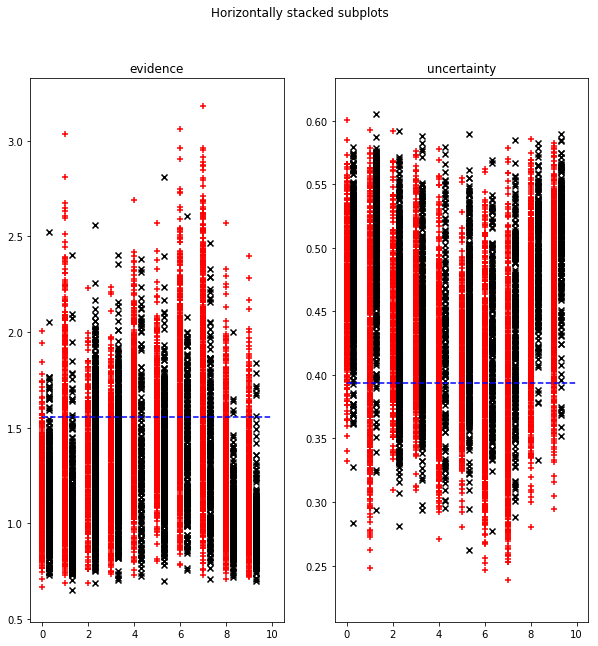

In [16]:
###keras KL activated model 47 epochs
# print(test_ds)
Predictions = displayEvidence(model,test_ds)

In [184]:
Predictions.to_csv("predictions_messingabout.csv")

10000
accuracy:       label  evidence  uncertainty
Acc                              
0.0    371       371          371
1.0    629       629          629
mean Acc
0.0    0.005302
Name: evidence, dtype: float64
std Acc
0.0    0.029481
Name: evidence, dtype: float64
evidence Threshold >= correct:  0.034782904414107405
uncertainty Threshold <= correct:  0.972050163608895
Uncertainty
Passed correct answers: (462, 4)
Accepted incorrect answers (19, 4)
Evidence
Passed correct answers: (464, 4)
Accepted incorrect answers (19, 4)


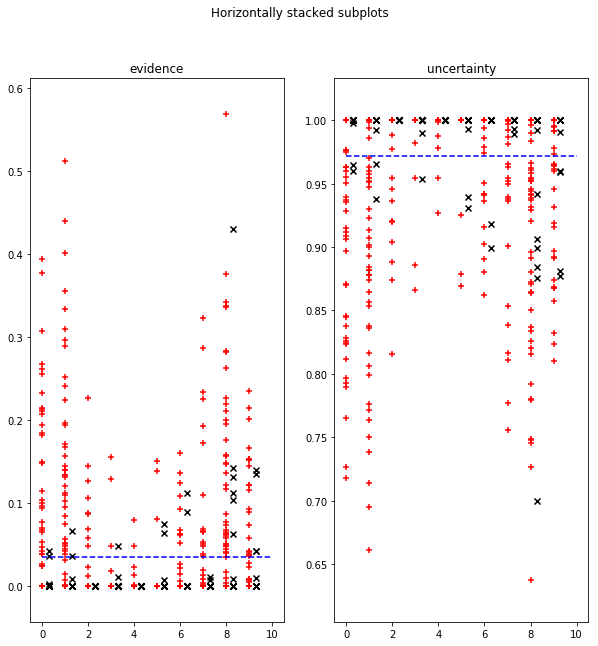

In [90]:
###keras KL activated model 47 epochs
# print(test_ds)
Predictions = displayEvidence(model,test_ds)

10000
accuracy:       label  evidence  uncertainty
Acc                              
0.0    371       371          371
1.0    629       629          629
mean Acc
0.0    0.049937
Name: evidence, dtype: float64
std Acc
0.0    0.049249
Name: evidence, dtype: float64
evidence Threshold >= correct:  0.09918640225923739
uncertainty Threshold <= correct:  0.9141201535881612
Uncertainty
Passed correct answers: (425, 4)
Accepted incorrect answers (47, 4)
Evidence
Passed correct answers: (436, 4)
Accepted incorrect answers (42, 4)


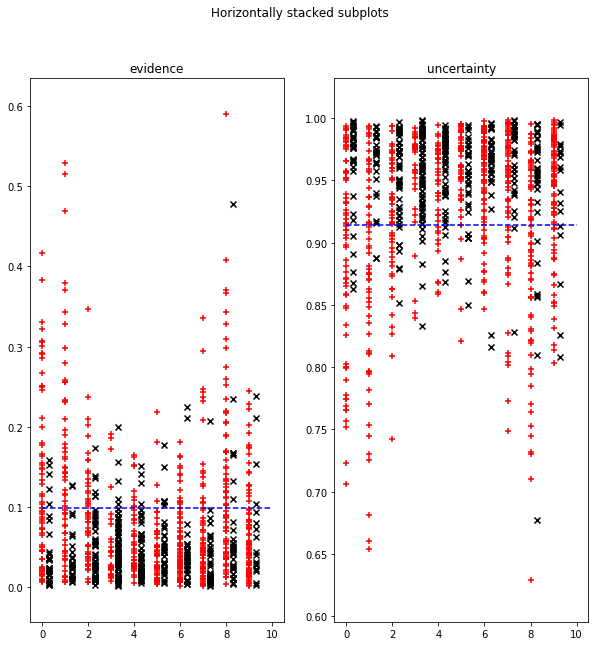

In [82]:
###keras KL activated model 47 epochs
# print(test_ds)
Predictions = displayEvidence(model,test_ds)

In [37]:
Predictions.to_csv("predictions_2.csv")
ar = [1,2,3,4,5,6,7,8,9,10]
ar = [1,1,1,1,1,1,1,1,1,10]
ar = [0,0,0,0,0,0,0,0,1,10]
print(np.mean(ar))


1.1


              label  evidence  uncertainty
Acc                                       
0.000000e+00    377       377          377
1.192093e-07    136       136          136
2.384186e-07     60        60           60
3.576278e-07     61        61           61
4.768370e-07     38        38           38
5.960463e-07     33        33           33
7.152555e-07     30        30           30
8.344647e-07     29        29           29
9.536739e-07     32        32           32
1.072883e-06     12        12           12
1.192092e-06     24        24           24
1.311301e-06     18        18           18
1.430510e-06     18        18           18
1.549720e-06     15        15           15
1.668929e-06     18        18           18
1.788138e-06     12        12           12
1.907347e-06     14        14           14
2.026556e-06     11        11           11
2.145765e-06     13        13           13
2.264974e-06     20        20           20
2.384183e-06     13        13           13
2.503392e-0

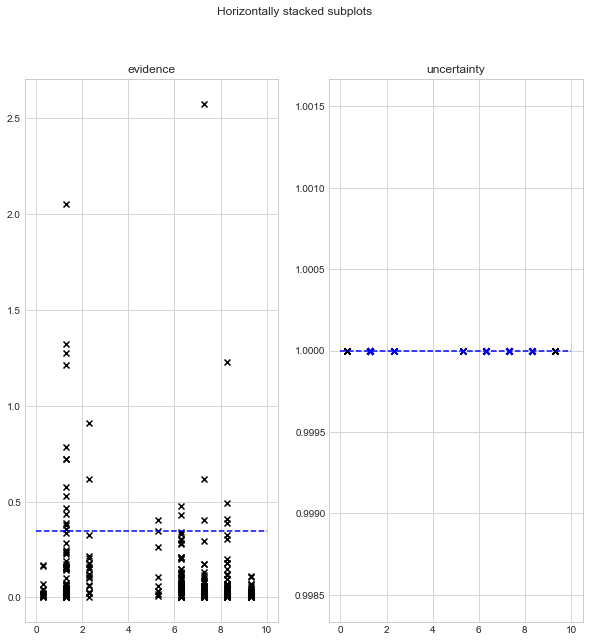

In [12]:
print(Predictions.groupby("Acc").count())
print(Predictions.groupby("Acc").mean())
print(Predictions.groupby("Acc").std())
E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
E_threshold = E_threshold.iloc[0]
print("evidence Threshold >= correct: ", E_threshold)
U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
U_threshold = U_threshold.iloc[0]
print("uncertainty Threshold <= correct: ", U_threshold)

print("Uncertainty")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >=U_threshold)].sort_values("uncertainty").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

print("Evidence")
print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] <= E_threshold)].sort_values("evidence").shape)
print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)

fig, axs = plt.subplots(1, 2)
    
correct_rows = Predictions.loc[Predictions['Acc'] == True]
incorrect_rows = Predictions.loc[Predictions['Acc'] == False]


E_correct_rows_missed = Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] <= E_threshold)].sort_values("evidence")
E_incorrect_rows_accepted = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence")


U_correct_rows_missed = Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >=U_threshold)].sort_values("uncertainty")
U_incorrect_rows_accepted = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty")

fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(U_correct_rows_missed['label']-.2,U_correct_rows_missed['evidence'],c ='g',marker='+')
axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].scatter(U_incorrect_rows_accepted['label']+.3,U_incorrect_rows_accepted['evidence'],c ='b',marker='x')
axs[0].plot(np.repeat(E_threshold,11),'b--')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(E_correct_rows_missed['label'],E_correct_rows_missed['uncertainty'],c ='g',marker='+')
axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].scatter(E_incorrect_rows_accepted['label']+.3,E_incorrect_rows_accepted['uncertainty'],c ='b',marker='x')
axs[1].plot(np.repeat(U_threshold,11),'b--')

axs[1].set_title("uncertainty")

fig.set_size_inches(10, 10)
plt.show()